In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense, Dropout
from keras.models import Model,Sequential, load_model
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score,adjusted_rand_score,v_measure_score, completeness_score, homogeneity_score, silhouette_score,roc_curve, auc, f1_score, precision_recall_curve, precision_score,recall_score,accuracy_score,confusion_matrix
from utils import *

In [23]:
DATA_DIR = '/Users/PeterC/Documents/gt/practicum/autoencoders/data/'
DATA_DIR = '/Users/chenpete/Documents/ESP/practicum/autoencoders/data/'

non_scale_cols = ['time','y_early','y_rank','y_count','y']
param_cols = [
        'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60','x61']

y_col = 'y_early'
early_step = 4

df = pd.read_csv(DATA_DIR + 'paper_mill_rare_events.csv')
df['time'] = pd.to_datetime(df['time'])
X_train, X_test, y_train, y_test,y_rank_train, y_rank_test,y_count_train, y_count_test = preprocess_paper_mill_data(df,param_cols,y_col, non_scale_cols,early_step)
X = X_train.append(X_test)

nonfailures_idx = y_rank_test == 0
early1_idx= y_rank_test == 1
early2_idx= y_rank_test == 2
early3_idx= y_rank_test == 3
early4_idx = y_rank_test == 4
early5_idx= y_rank_test == 5

In [15]:
autoencoder_model = load_model('autoencoder_32_16_32.h5')

#### t-sne - raw

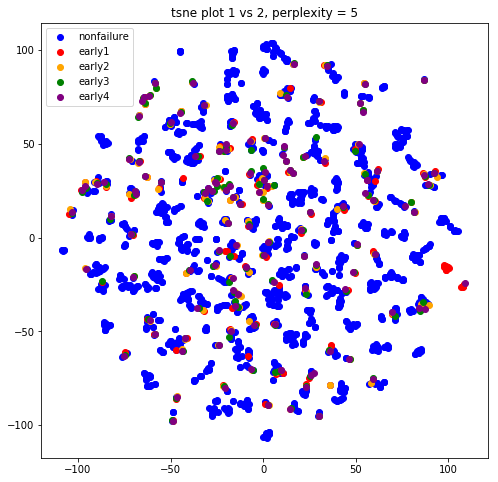

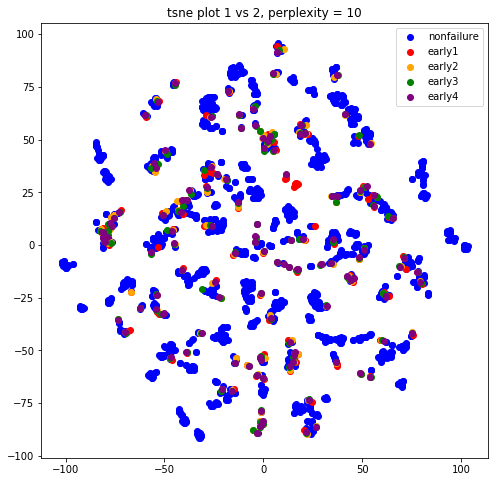

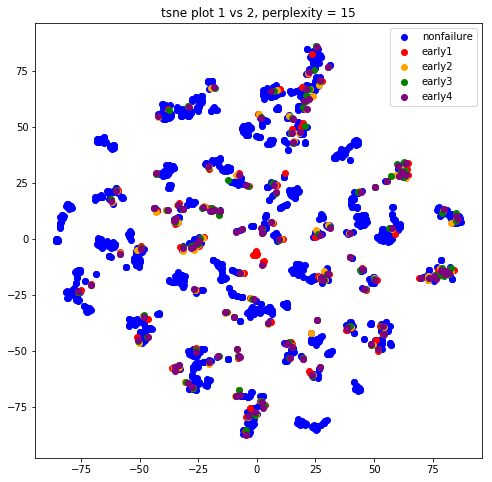

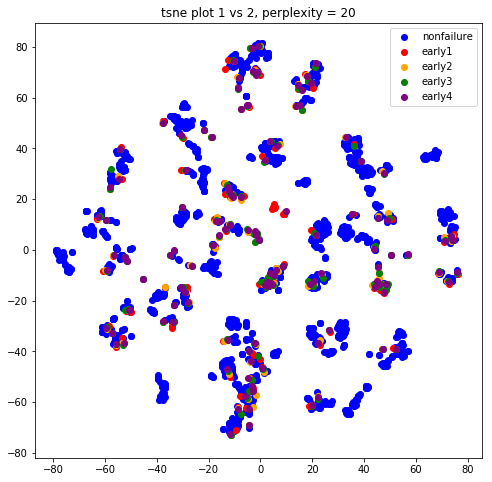

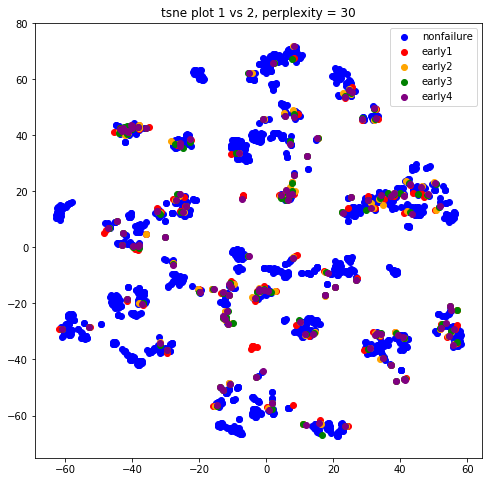

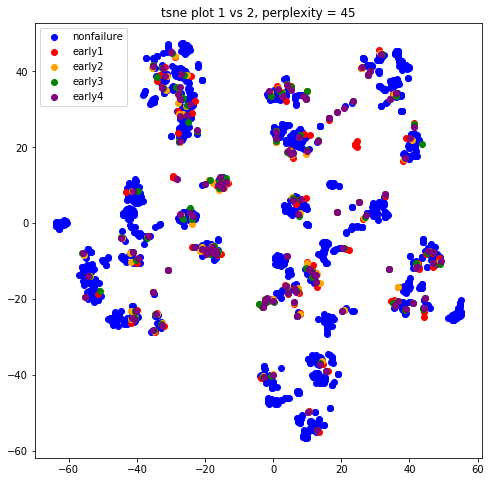

In [42]:
perplexity_list = [5,10,15,20,30,45]

for p in perplexity_list:
    tsne = TSNE(n_components=2,perplexity=p)
    tsne_output = tsne.fit_transform(X_test)
    
    plt.figure(figsize=(8,8))
    plt.scatter(tsne_output[nonfailures_idx,0],tsne_output[nonfailures_idx,1],color='blue')
    plt.scatter(tsne_output[early1_idx,0],tsne_output[early1_idx,1],color='red')
    plt.scatter(tsne_output[early2_idx,0],tsne_output[early2_idx,1],color='orange')
    plt.scatter(tsne_output[early3_idx,0],tsne_output[early3_idx,1],color='green')
    plt.scatter(tsne_output[early4_idx,0],tsne_output[early4_idx,1],color='purple')
    plt.legend(['nonfailure','early1','early2','early3','early4'])
    plt.title('tsne plot 1 vs 2, perplexity = {}'.format(p))

#### t-sne - encoded

In [16]:
encoded_model = Sequential()
encoded_model.add(Dense(units = 32,activation='relu',input_shape = (len(param_cols),),weights = autoencoder_model.layers[0].get_weights()))
encoded_model.add(Dense(units = 16,activation='relu',weights = autoencoder_model.layers[1].get_weights()))

In [17]:
encoded_array = encoded_model.predict(X)
encoded_array_train = encoded_model.predict(X_train)
encoded_array_test = encoded_model.predict(X_test)

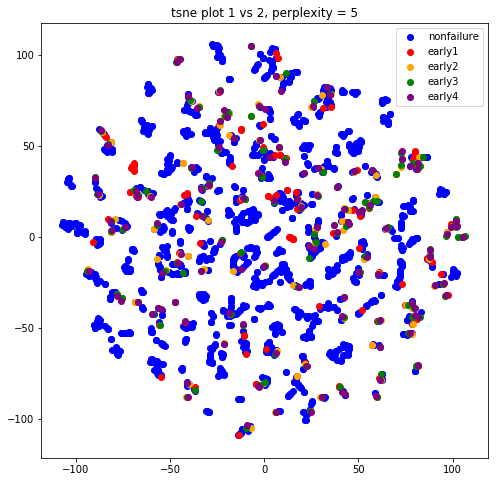

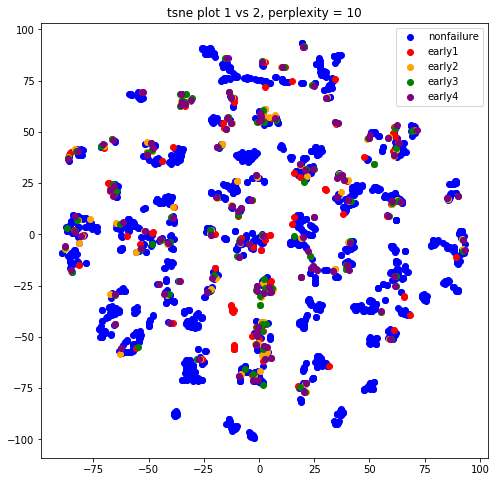

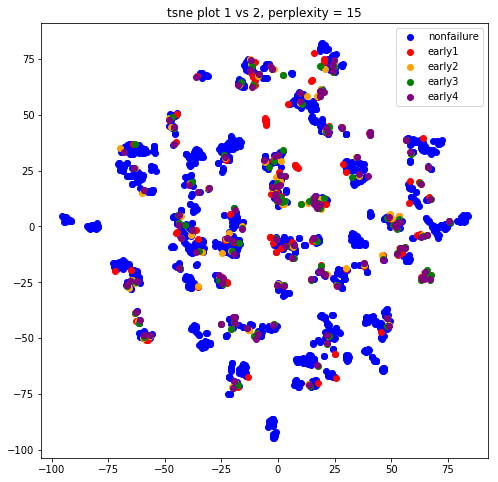

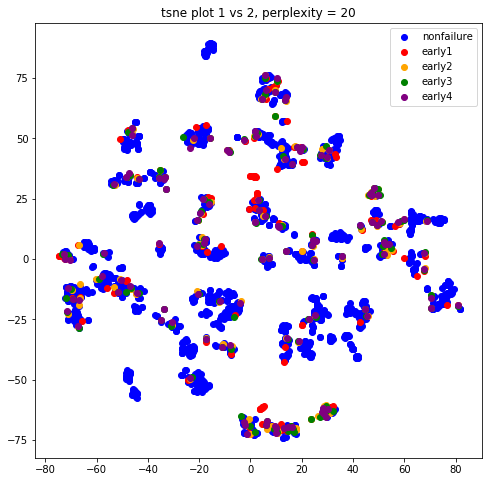

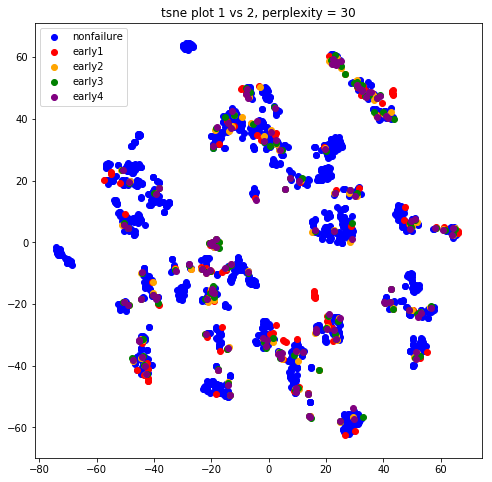

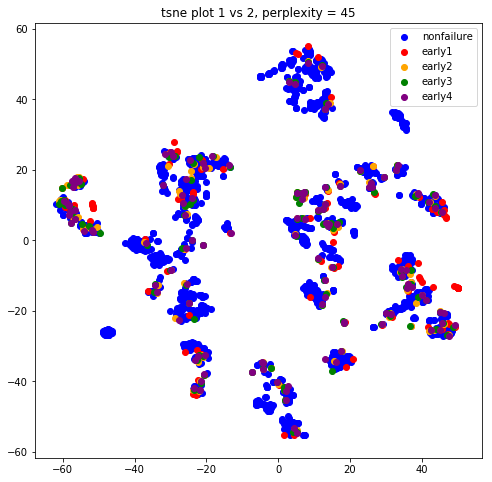

In [51]:
for p in perplexity_list:
    tsne_encoded = TSNE(n_components=2,perplexity=p)
    tsne_output_encoded = tsne_encoded.fit_transform(encoded_array_test)
    
    plt.figure(figsize=(8,8))
    plt.scatter(tsne_output_encoded[nonfailures_idx,0],tsne_output_encoded[nonfailures_idx,1],color='blue')
    plt.scatter(tsne_output_encoded[early1_idx,0],tsne_output_encoded[early1_idx,1],color='red')
    plt.scatter(tsne_output_encoded[early2_idx,0],tsne_output_encoded[early2_idx,1],color='orange')
    plt.scatter(tsne_output_encoded[early3_idx,0],tsne_output_encoded[early3_idx,1],color='green')
    plt.scatter(tsne_output_encoded[early4_idx,0],tsne_output_encoded[early4_idx,1],color='purple')
    plt.legend(['nonfailure','early1','early2','early3','early4'])
    plt.title('tsne plot 1 vs 2, perplexity = {}'.format(p))

#### t-sne - xgb selected variables 

In [46]:
import ast

autoencoder_model_xgb = load_model('autoencoder_12_6_12.h5')
param_cols_xgb = ast.literal_eval(autoencoder_model_xgb.name)
encoded_model_xgb = Sequential()
encoded_model_xgb.add(Dense(units = 12,activation='relu',input_shape = (len(param_cols_xgb),),weights = autoencoder_model_xgb.layers[0].get_weights()))
encoded_model_xgb.add(Dense(units = 6,activation='relu',weights = autoencoder_model_xgb.layers[1].get_weights()))

In [48]:
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb,y_rank_train_xgb, y_rank_test_xgb,y_count_train_xgb, y_count_test_xgb = preprocess_paper_mill_data(df,param_cols_xgb,y_col, non_scale_cols,early_step)

In [49]:
X_xgb = X_train_xgb.append(X_test_xgb)
encoded_xgb_array = encoded_model_xgb.predict(X_xgb)
encoded_xgb_array_train = encoded_model_xgb.predict(X_train_xgb)
encoded_xgb_array_test = encoded_model_xgb.predict(X_test_xgb)

#### t-sne - xgb selected variables - encoded

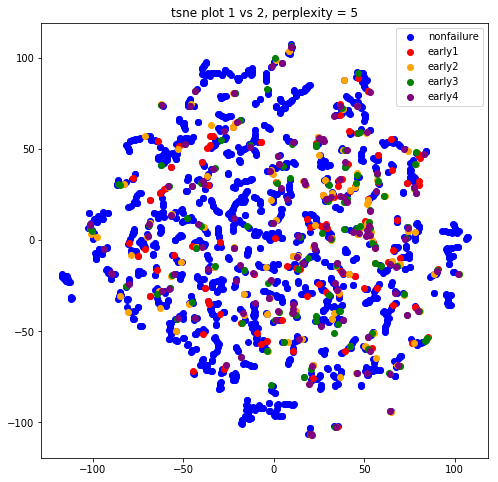

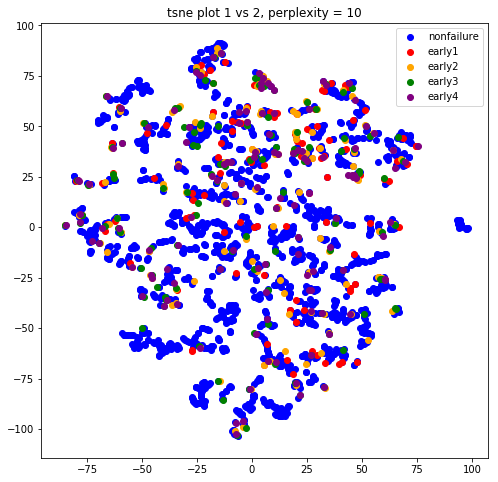

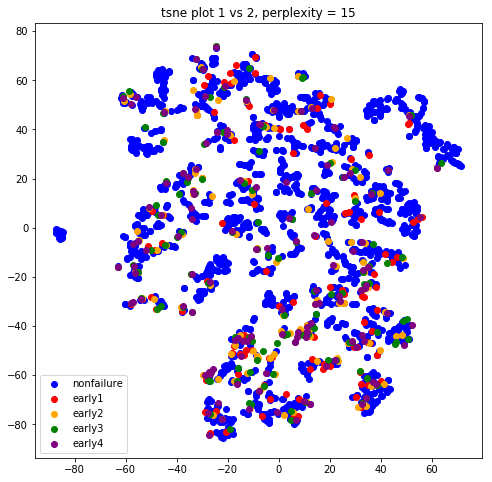

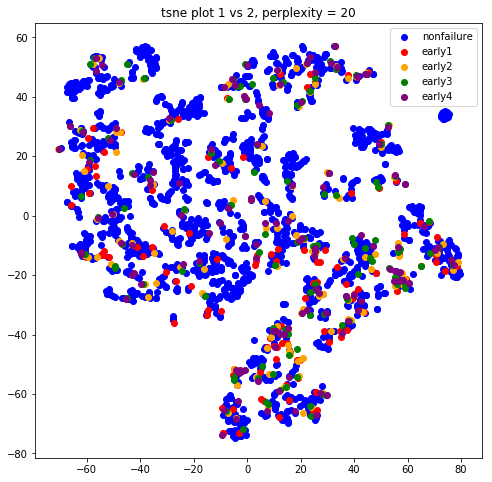

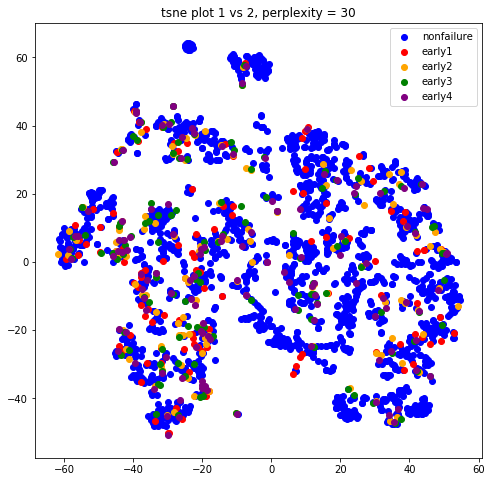

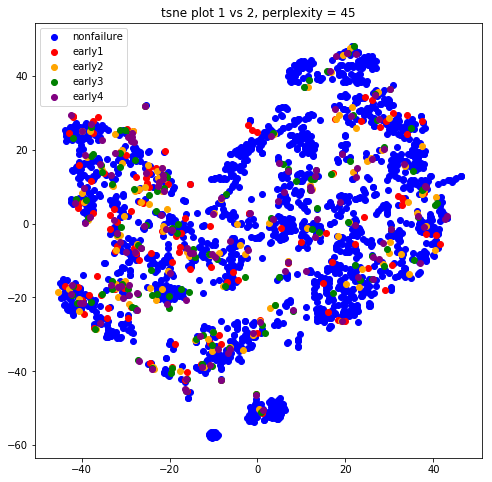

In [50]:
for p in perplexity_list:
    tsne_encoded_xgb = TSNE(n_components=2,perplexity=p)
    tsne_output_encoded_xgb = tsne_encoded_xgb.fit_transform(encoded_xgb_array_test)
    
    plt.figure(figsize=(8,8))
    plt.scatter(tsne_output_encoded_xgb[nonfailures_idx,0],tsne_output_encoded_xgb[nonfailures_idx,1],color='blue')
    plt.scatter(tsne_output_encoded_xgb[early1_idx,0],tsne_output_encoded_xgb[early1_idx,1],color='red')
    plt.scatter(tsne_output_encoded_xgb[early2_idx,0],tsne_output_encoded_xgb[early2_idx,1],color='orange')
    plt.scatter(tsne_output_encoded_xgb[early3_idx,0],tsne_output_encoded_xgb[early3_idx,1],color='green')
    plt.scatter(tsne_output_encoded_xgb[early4_idx,0],tsne_output_encoded_xgb[early4_idx,1],color='purple')
    plt.legend(['nonfailure','early1','early2','early3','early4'])
    plt.title('tsne plot 1 vs 2, perplexity = {}'.format(p))